# Imports

In [63]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
import os
import glob
import geometric_sampling as gs
import pandas as pd
import numpy as np
import itertools
from tqdm import tqdm
import rpy2.robjects as ro
from rpy2.robjects import numpy2ri, default_converter
from rpy2.robjects.conversion import localconverter
from package_sampling.utils import inclusion_probabilities

In [65]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [66]:
%%R

library(WaveSampling)
library(sampling)
library(BalancedSampling)


# Moran and Local Balance Score

In [67]:
def score_all_samples_moran_lb(coords, probs, sample_indices_list):
    """
    coords          : an (N×2)-array of spatial coordinates
    probs           : length-N array of inclusion probabilities
    sample_indices_list : list of length-n integer numpy arrays (0-based indices)

    Returns an (S×2) numpy array of [IB, SBLB] for each of the S samples.
    """

    # Convert Python list of numpy arrays into an R list of integer vectors
    #   * add +1 because R is 1-based
    r_sample_list = ro.ListVector({
        str(i+1): ro.IntVector(sample_idx.astype(int) + 1)
        for i, sample_idx in enumerate(sample_indices_list)
    })

    with localconverter(default_converter + numpy2ri.converter):
        ro.globalenv['coords'] = coords
        ro.globalenv['probs'] = probs
        # Precompute W once
        ro.r("""
            W0 <- wpik(coords, probs)
            W <- W0 - diag(diag(W0))
            diag(W) <- 0
        """)
        ro.globalenv['samples'] = r_sample_list

        # Define an R function that loops over all samples
        ro.r("""
            score_samples <- function(W, probs, coords, samples_list) {
              S <- length(samples_list)
              IBs   <- numeric(S)
              SBLBs <- numeric(S)

              for (i in seq_len(S)) {
                samp_idx <- samples_list[[i]]
                mask <- integer(length(probs))
                mask[samp_idx] <- 1

                IBs[i]   <- tryCatch(IB(W, mask),        error = function(e) Inf)
                SBLBs[i] <- tryCatch(sblb(probs, coords, samp_idx), error = function(e) Inf)
              }
              # return as a 2-column matrix
              cbind(IB = IBs, SBLB = SBLBs)
            }
        """)

        # Call it once
        result = ro.r("score_samples(W, probs, coords, samples)")
        # result comes back as an R matrix  S×2

    # Turn it into an (S×2) numpy array
    with localconverter(default_converter + numpy2ri.converter):
        np_result = np.array(result)
    return np_result[:, 0], np_result[:, 1]


# Loading Population

In [68]:
import os
import glob
import numpy as np

DATA_DIR = "../data_samples/coords_probs"
csv_paths = glob.glob(os.path.join(DATA_DIR, "*.csv"))

coords_dict = {}
probs_dict = {}

for fp in csv_paths:
    print(fp)
    if 'swiss' not in fp:
        name = os.path.splitext(os.path.basename(fp))[0]  # e.g. 'meuse_eq_n=5'
        data = np.loadtxt(fp, delimiter=",", skiprows=1)
        coords = data[:, :2]
        probs  = data[:, -1]
        print(name)
        
        parts = name.split('_')
        if len(parts) < 2:
            print(f"Filename pattern unexpected: {name}")
            continue
        
        coord_name = parts[0]
        prob_name  = parts[1]
        # Join any extra parts (like n=5)
        extra = "_".join(parts[2:]) if len(parts) > 2 else "" 
        
        # Normalize values
        coord_name = 'cluster' if coord_name == 'clust' else coord_name
        prob_name = 'equal' if prob_name == 'eq' else ('unequal' if prob_name == 'uneq' else prob_name)
        
        # Build final key (including n=5 if present)
        key = f"{coord_name}_{prob_name}"
        if extra:
            key += f"_{extra}"

        coords_dict[key] = coords
        probs_dict[key] = probs  # or use probs_dict[key] = {'coords': coords, 'probs': probs}

print(coords_dict.keys())
print(probs_dict.keys())
# Access example: probs_dict['meuse_equal_n=5']

../data_samples/coords_probs/swiss_uneq_n=5.csv
../data_samples/coords_probs/swiss_uneq_n=10.csv
../data_samples/coords_probs/grid_uneq.csv
grid_uneq
../data_samples/coords_probs/meuse_eq.csv
meuse_eq
../data_samples/coords_probs/meuse_eq_n=5.csv
meuse_eq_n=5
../data_samples/coords_probs/swiss_eq_n=8.csv
../data_samples/coords_probs/swiss_eq_n=20.csv
../data_samples/coords_probs/swiss_eq_n=10.csv
../data_samples/coords_probs/swiss_eq_n=4.csv
../data_samples/coords_probs/meuse_eq_n=10.csv
meuse_eq_n=10
../data_samples/coords_probs/clust_eq.csv
clust_eq
../data_samples/coords_probs/meuse_uneq_n=5.csv
meuse_uneq_n=5
../data_samples/coords_probs/swiss_uneq_n=20.csv
../data_samples/coords_probs/meuse_uneq_n=10.csv
meuse_uneq_n=10
../data_samples/coords_probs/swiss_eq_n=5.csv
../data_samples/coords_probs/swiss_e222q.csv
../data_samples/coords_probs/clust_uneq.csv
clust_uneq
../data_samples/coords_probs/swiss_uneq_n=8.csv
../data_samples/coords_probs/meuse_uneq.csv
meuse_uneq
../data_samples/

# Evaluation Function

In [75]:
def top_n_records(df: pd.DataFrame,
                  name_cols: list,
                  sort_col: str = 'exp_moran',
                  k: int = 10,
                  smallest: bool = True) -> pd.DataFrame:

    df_copy = df.copy()

    df_copy['name'] = df_copy[name_cols].astype(str).agg(' - '.join, axis=1)

    if smallest:
        return df_copy.nsmallest(k, sort_col)[['name', sort_col]].reset_index(drop=True)
    return df_copy.nlargest(k, sort_col)[['name', sort_col]].reset_index(drop=True)

In [53]:
def evaluate(coords_dict, probs_dict, n_values, zone_list,
             sort_method_list, zonal_sort_list,
             tolerance=5, split_size=1e-3, zone_mode_list=("sweep",)):
    rows = []
    combos = itertools.product(n_values, zone_list, sort_method_list, zonal_sort_list, zone_mode_list)

    for n, zones, sort_method, zonal_sort, zone_mode in combos:
        for coord_name, coords in coords_dict.items():
            prob_container = probs_dict.get(coord_name, None)

            if prob_container is None:
                raise KeyError(f"No probs for coord set '{coord_name}'")

            # normalize to dict
            if isinstance(prob_container, np.ndarray):
                prob_iter = { "default": prob_container }
            else:
                prob_iter = prob_container  # dict-like

            for prob_name, probs in prob_iter.items():
                mod_probs = inclusion_probabilities(probs, n=n)

                kss = gs.sampling.KMeansSpatialSamplingSimple(
                    coords, mod_probs,
                    n=n,
                    n_zones=zones if isinstance(zones, tuple) else (zones, zones),
                    tolerance=tolerance,
                    split_size=split_size,
                    zone_mode=zone_mode,
                    sort_method=sort_method,
                    zonal_sort=zonal_sort,
                    max_missed_samples=1
                )

                density_exp = np.round(kss.expected_score(), 4)
                density_var = np.round(kss.var_score(), 4)
                # ... other metrics

                rows.append({
                    "coord": coord_name,
                    "prob": prob_name,
                    "n": n,
                    "zones": zones,
                    "zone_mode": zone_mode,
                    "sort_method": sort_method,
                    "zonal_sort": zonal_sort,
                    "exp_density": density_exp,
                    "var_density": density_var,
                })

    return pd.DataFrame(rows)


In [54]:
df = evaluate(
    coords_dict,
    probs_dict,
    n_values=[4],
    # zone_list=[(1, 1), (2, 2), (3, 3)],
    zone_list=[2, 3, 4],
    sort_method_list=['distance_0', 'projection'],
    zonal_sort_list=[None, 'distance_0', 'projection'],
    tolerance=5,
    split_size=1e-3,
)

TypeError: PopulationSimple._normalize() takes 1 positional argument but 2 were given

In [ ]:
summary = df.pivot_table(
    columns=['zones', 'zonal_sort', 'bar_sort'],
    # values=['exp_density', 'exp_moran', 'exp_lb', 'var_density', 'var_moran', 'var_lb'],
    values=['exp_moran',],
    index=['coord', 'prob'],
    aggfunc='first'
)

summary

exp_moran                                              \
zones                    2                                               
zonal_sort            None            distance_0            projection   
bar_sort        distance_0 projection distance_0 projection distance_0   
coord   prob                                                             
cluster equal      -0.1253    -0.1276    -0.1985    -0.2043    -0.1915   
        unequal    -0.0786    -0.1228    -0.1248    -0.1248    -0.1248   
grid    equal      -0.1116    -0.2019    -0.1781    -0.1758    -0.1758   
        unequal    -0.1174    -0.0574    -0.1174    -0.1174    -0.1174   
meuse   equal      -0.2683    -0.2547    -0.2745    -0.2745    -0.2745   
        unequal    -0.1968    -0.1676    -0.2193    -0.2183    -0.2193   
random  equal      -0.1618    -0.1318    -0.1603    -0.1618    -0.1600   
        unequal    -0.0869    -0.1104    -0.1336    -0.1341    -0.1336   

                                                                        \
zones                               3                                    
zonal_sort                       None            distance_0              
bar_sort        projection distance_0 projection distance_0 projection   
coord   prob                                                             
cluster equal      -0.1985    -0.2449    -0.1455    -0.2392    -0.2384   
        unequal    -0.1248    -0.1149    -0.1299    -0.1058    -0.1294   
grid    equal      -0.1781    -0.1489    -0.1537    -0.1900    -0.1576   
        unequal    -0.1174    -0.0971    -0.0973    -0.1215    -0.1215   
meuse   equal      -0.2745    -0.2612    -0.1856    -0.3335    -0.3335   
        unequal    -0.2183    -0.1839    -0.1416    -0.2228    -0.2228   
random  equal      -0.1603    -0.1551    -0.1615    -0.1573    -0.1573   
        unequal    -0.1336    -0.0977    -0.1498    -0.1219    -0.1274   

                                                                        \
zones                                          4                         
zonal_sort      projection                  None            distance_0   
bar_sort        distance_0 projection distance_0 projection distance_0   
coord   prob                                                             
cluster equal      -0.2385    -0.2485    -0.3012    -0.2648    -0.3162   
        unequal    -0.1068    -0.1083    -0.1405    -0.0956    -0.1454   
grid    equal      -0.1708    -0.1478    -0.1527    -0.1396    -0.2041   
        unequal    -0.1229    -0.1197    -0.0938    -0.1060    -0.1224   
meuse   equal      -0.3335    -0.3335    -0.2753    -0.1998    -0.2930   
        unequal    -0.2228    -0.2228    -0.2206    -0.1668    -0.2395   
random  equal      -0.1571    -0.1568    -0.1502    -0.1106    -0.1756   
        unequal    -0.1245    -0.1245    -0.1096    -0.0926    -0.1158   

                                                  
zones                                             
zonal_sort                 projection             
bar_sort        projection distance_0 projection  
coord   prob                                      
cluster equal      -0.3118    -0.3211    -0.3240  
        unequal    -0.1450    -0.1302    -0.1267  
grid    equal      -0.1683    -0.1817    -0.1761  
        unequal    -0.1186    -0.1085    -0.1220  
meuse   equal      -0.2926    -0.3298    -0.3271  
        unequal    -0.2307    -0.2223    -0.2203  
random  equal      -0.1734    -0.1756    -0.1756  
        unequal    -0.1158    -0.1112    -0.1116

# Meuse

In [70]:
def evaluate_meuse(
        coords_dict,
        probs_dict,
        n_values=[16],
        zone_list=[(3, 3)],
        sort_method_list = [
            'lexico-xy', 'lexico-yx', 'random', 'angle_0', 'distance_0',
            'projection', 'center', 'spiral', 'max',
            'hilbert', 'farthest', 'grid', 'shell'
        ],       
        zonal_sort_list = [
            'lexico-xy', 'lexico-yx', 'random', 'angle_0', 'distance_0',
            'projection', 'center', 'spiral', 'max',
            'hilbert', 'farthest', 'grid', 'shell'
        ],
        zone_mode_list=['sweep' 'cluster'],
        tolerance=5,
        split_size=1e-3,
):
    records = []

    # pre‐compute all combinations
    combos = list(itertools.product(
        n_values,
        zone_list,
        zone_mode_list,
        zonal_sort_list,
        sort_method_list
    ))
    coords = coords_dict['meuse_unequal']
    probs = probs_dict['meuse_unequal']

    print(np.sum(probs))
    best_moran_sofar = 0

    for n, zones, zone_mode, zonal_sort, sort_method in tqdm(
        combos,
        desc="Total combos",
        unit="combo"
    ):

        # print(n, zones, zone_mode, zonal_sort, sort_method)

        modified_probs = inclusion_probabilities(probs, n=n)
        kss = gs.sampling.KMeansSpatialSamplingSimple(
            coords, modified_probs,
            n=n,
            n_zones=zones,
            tolerance=tolerance,
            split_size=split_size,
            zone_mode=zone_mode,
            sort_method=sort_method,
            zonal_sort=zonal_sort,
            max_missed_samples=1
        )

        density_expected = np.round(kss.expected_score(), 4)
        density_val = np.round(kss.var_score(), 4)

        moran_scores, lb_scores = score_all_samples_moran_lb(coords, modified_probs, kss.all_samples)

        moran_expected = np.round(kss.expected_score(moran_scores), 4)
        moran_val = np.round(kss.var_score(moran_scores), 4)

        lb_expected = np.round(kss.expected_score(lb_scores), 4)
        lb_val = np.round(kss.var_score(lb_scores), 4)

        if moran_expected < best_moran_sofar:
            best_moran_sofar = moran_expected
            print()

        records.append({
            'n': n,
            'zones': zones if zone_mode == 'cluster' else f"{zones[0]}×{zones[1]}",
            'zone_mode': zone_mode,
            'bar_sort': sort_method,
            'zonal_sort': zonal_sort if zonal_sort else 'None',
            'exp_density': density_expected,
            'exp_moran': moran_expected,
            'exp_lb': lb_expected,
            'var_density': density_val,
            'var_moran': moran_val,
            'var_lb': lb_val,
        })

    return pd.DataFrame.from_records(records)


In [71]:
df = evaluate_meuse(
    coords_dict,
    probs_dict,
    n_values=[15],
    # zone_list=[(1, 1), (2, 2), (3, 3), (4, 4), (3, 4), (4, 3)],
    zone_list=[ 4, 12, 16],
    sort_method_list=[
            'lexico-xy', 'lexico-yx', 'random', 'angle_0', 'distance_0',
            'projection', 'center', 'spiral', 'max',
            'hilbert', 'farthest', 'grid', 'shell'
        ],
    zonal_sort_list=[None, 'lexico-xy', 'lexico-yx', 'random', 'angle_0', 'distance_0',
            'projection', 'center', 'spiral', 'max',
            'hilbert', 'farthest', 'grid', 'shell'],
    # zonal_sort_list=[None],
    zone_mode_list=['cluster'],
    tolerance=5,
    split_size=1e-3,
)

4.0


Total combos:   0%|          | 0/546 [00:00<?, ?combo/s]

Total combos:   0%|          | 1/546 [00:16<2:28:26, 16.34s/combo]

Total combos:   1%|          | 3/546 [00:38<1:45:33, 11.66s/combo]

Total combos:   1%|          | 5/546 [00:53<1:24:37,  9.39s/combo]

Total combos:   3%|▎         | 14/546 [02:07<1:13:54,  8.34s/combo]

Total combos:   3%|▎         | 18/546 [02:39<1:10:36,  8.02s/combo]

Total combos:   4%|▎         | 20/546 [02:56<1:12:51,  8.31s/combo]

Total combos:   4%|▍         | 23/546 [03:19<1:07:50,  7.78s/combo]

Total combos:  12%|█▏        | 66/546 [09:06<1:02:31,  7.82s/combo]

Total combos:  14%|█▍        | 79/546 [10:56<1:08:39,  8.82s/combo]

Total combos:  15%|█▌        | 84/546 [11:36<1:03:31,  8.25s/combo]

Total combos: 100%|██████████| 546/546 [1:35:51<00:00, 10.53s/combo]


In [72]:
summary = df.pivot_table(
    values=['exp_density', 'exp_moran', 'exp_lb'],
    columns=['n', 'zones'],
    index=['zonal_sort', 'bar_sort'],
    aggfunc='first'
)

# 1) Temporarily
with pd.option_context('display.max_rows', None):
    display(summary)



exp_density                  exp_lb                  \
n                              15                      15                   
zones                          4       12      16      4       12      16   
zonal_sort bar_sort                                                         
None       angle_0         0.0746  0.0814  0.0707  0.2418  0.2416  0.2426   
           center          0.0800  0.0702  0.0718  0.2415  0.2392  0.2449   
           distance_0      0.0615  0.0803  0.0753  0.2478  0.2361  0.2391   
           farthest        0.0733  0.0676  0.0701  0.2530  0.2490  0.2349   
           grid            0.0736  0.0762  0.0847  0.2392  0.2370  0.2370   
           hilbert         0.0829  0.0689  0.0771  0.2303  0.2459  0.2309   
           lexico-xy       0.0693  0.0750  0.0770  0.2455  0.2376  0.2363   
           lexico-yx       0.0733  0.0771  0.0769  0.2263  0.2355  0.2316   
           max             0.0662  0.0788  0.0816  0.2361  0.2393  0.2453   
           projection      0.0741  0.0889  0.0784  0.2363  0.2376  0.2416   
           random          0.0771  0.0677  0.0737  0.2409  0.2381  0.2345   
           shell           0.0787  0.0767  0.0638  0.2490  0.2328  0.2359   
           spiral          0.0733  0.0780  0.0834  0.2372  0.2501  0.2449   
angle_0    angle_0         0.0548  0.0513  0.0525  0.2356  0.2337  0.2343   
           center          0.0708  0.0626  0.0475  0.2453  0.2394  0.2298   
           distance_0      0.0588  0.0562  0.0615  0.2443  0.2377  0.2345   
           farthest        0.0656  0.0513  0.0546  0.2412  0.2433  0.2399   
           grid            0.0534  0.0483  0.0518  0.2389  0.2391  0.2343   
           hilbert         0.0574  0.0528  0.0522  0.2365  0.2397  0.2364   
           lexico-xy       0.0598  0.0544  0.0438  0.2303  0.2404  0.2379   
           lexico-yx       0.0663  0.0551  0.0552  0.2388  0.2312  0.2437   
           max             0.0493  0.0513  0.0484  0.2405  0.2424  0.2259   
           projection      0.0533  0.0578  0.0518  0.2348  0.2312  0.2343   
           random          0.0549  0.0549  0.0540  0.2423  0.2441  0.2387   
           shell           0.0510  0.0575  0.0590  0.2463  0.2426  0.2397   
           spiral          0.0595  0.0488  0.0452  0.2430  0.2374  0.2306   
center     angle_0         0.0801  0.0720  0.0730  0.2370  0.2317  0.2363   
           center          0.0686  0.0658  0.0762  0.2385  0.2290  0.2373   
           distance_0      0.0680  0.0723  0.0626  0.2339  0.2345  0.2344   
           farthest        0.0898  0.0827  0.0776  0.2456  0.2319  0.2302   
           grid            0.0726  0.0705  0.0785  0.2262  0.2331  0.2411   
           hilbert         0.0700  0.0670  0.0705  0.2289  0.2430  0.2394   
           lexico-xy       0.0579  0.0780  0.0823  0.2254  0.2435  0.2361   
           lexico-yx       0.0747  0.0726  0.0719  0.2506  0.2411  0.2438   
           max             0.0652  0.0751  0.0754  0.2441  0.2255  0.2455   
           projection      0.0824  0.0600  0.0708  0.2350  0.2441  0.2372   
           random          0.0948  0.0689  0.0717  0.2346  0.2273  0.2402   
           shell           0.0779  0.0669  0.0821  0.2433  0.2395  0.2472   
           spiral          0.0801  0.0725  0.0702  0.2458  0.2383  0.2314   
distance_0 angle_0         0.0609  0.0738  0.0688  0.2315  0.2310  0.2469   
           center          0.0726  0.0683  0.0704  0.2392  0.2323  0.2354   
           distance_0      0.0595  0.0722  0.0684  0.2292  0.2379  0.2327   
           farthest        0.0803  0.0652  0.0725  0.2409  0.2293  0.2429   
           grid            0.0693  0.0623  0.0639  0.2427  0.2348  0.2348   
           hilbert         0.0743  0.0689  0.0611  0.2268  0.2355  0.2409   
           lexico-xy       0.0660  0.0707  0.0743  0.2248  0.2261  0.2336   
           lexico-yx       0.0630  0.0701  0.0731  0.2270  0.2275  0.2378   
           max             0.0715  0.0689  0.0757  0.2345  0.2420  0.2291   
           project

In [76]:
top_n_records(df, ['zonal_sort', 'bar_sort', 'zones'], k=10)

,name,exp_moran
0,projection - projection - 4,-0.3079
1,projection - lexico-xy - 4,-0.3078
2,projection - grid - 12,-0.3042
3,max - hilbert - 4,-0.3024
4,grid - hilbert - 4,-0.3006
5,projection - projection - 12,-0.3002
6,projection - hilbert - 12,-0.2991
7,distance_0 - hilbert - 16,-0.2982
8,max - max - 12,-0.2973
9,distance_0 - lexico-xy - 4,-0.2947


In [57]:
def evaluate_meuse_loop(
        coords_dict,
        probs_dict,
        num_loops=10,
        n_values=[4],
        zone_list=[(1, 1), (2, 2), (3, 3)],
        sort_method_list=[
            'lexico-xy', 'lexico-yx', 'random', 'angle_0', 'distance_0',
            'projection', 'center', 'spiral', 'max',
            'hilbert', 'farthest', 'grid', 'shell'
        ],
        zonal_sort_list=[
            'lexico-xy', 'lexico-yx', 'random', 'angle_0', 'distance_0',
            'projection', 'center', 'spiral', 'max',
            'hilbert', 'farthest', 'grid', 'shell'
        ],
        zone_mode_list=['sweep' 'cluster'],
        tolerance=5,
        split_size=1e-3,
):
    records = []
    kss_list = []

    # pre‐compute all combinations
    combos = list(itertools.product(
        n_values,
        zone_list,
        zone_mode_list,
        zonal_sort_list,
        sort_method_list
    ))
    coords = coords_dict['meuse_unequal']
    probs = probs_dict['meuse_unequal']

    best_moran_sofar = 0

    for _ in tqdm(range(num_loops), desc="Loops", unit="loop"):
        for n, zones, zone_mode, zonal_sort, sort_method in combos:
        # tqdm(
        #     combos,
        #     desc="Total combos",
        #     unit="combo"
        # ):

            # print(n, zones, zone_mode, zonal_sort, sort_method)

            modified_probs = inclusion_probabilities(probs, n=n)
            kss = gs.sampling.KMeansSpatialSamplingSimple(
                coords, modified_probs,
                n=n,
                n_zones=zones,
                tolerance=tolerance,
                split_size=split_size,
                zone_mode=zone_mode,
                sort_method=sort_method,
                zonal_sort=zonal_sort,
                max_missed_samples=1
            )
            kss_list.append(kss)

            density_expected = np.round(kss.expected_score(), 4)
            density_val = np.round(kss.var_score(), 4)

            moran_scores, lb_scores = score_all_samples_moran_lb(coords, modified_probs, kss.all_samples)

            moran_expected = np.round(kss.expected_score(moran_scores), 4)
            moran_val = np.round(kss.var_score(moran_scores), 4)

            lb_expected = np.round(kss.expected_score(lb_scores), 4)
            lb_val = np.round(kss.var_score(lb_scores), 4)

            if moran_expected < best_moran_sofar:
                best_moran_sofar = moran_expected
                print('\n====================================')
                print('A NEW BEST FOUND')
                print(f'Moran score: {moran_expected}' )
                print(f'zone_mode: {zone_mode}')
                print(f'zonal_sort: {zonal_sort}')
                print(f'bar_sort: {sort_method}')
                print(f'zones: {zones}')
            
            cluster_membership = tuple(kss.cluster_membership)  # Or .tolist() or .copy()
            records.append({
                'n': n,
                'zones': zones if zone_mode == 'cluster' else f"{zones[0]}×{zones[1]}",
                'zone_mode': zone_mode,
                'bar_sort': sort_method,
                'zonal_sort': zonal_sort if zonal_sort else 'None',
                'exp_density': density_expected,
                'exp_moran': moran_expected,
                'exp_lb': lb_expected,
                'var_density': density_val,
                'var_moran': moran_val,
                'var_lb': lb_val,
                'cluster_membership': cluster_membership,

            })

    return pd.DataFrame.from_records(records), kss_list


In [60]:
df, kss_list = evaluate_meuse_loop(
    coords_dict,
    probs_dict,
    num_loops=4,
    n_values=[15],
    # zone_list=[(1, 1), (2, 2)],#, (2, 1), (1, 2), (2, 3), (3, 2)],
    zone_list=[ (1, 1),],
    # zone_list=[12],
    sort_method_list=['hilbert'],
    #zonal_sort_list=[None, 'random', 'projection'],
    # zonal_sort_list=['shell', 'hilbert'],
    zonal_sort_list=[None],
    zone_mode_list=['sweep'],
    # zone_mode_list=['cluster'],
    tolerance=5,
    split_size=1e-3,
)

Loops:   0%|          | 0/4 [00:00<?, ?loop/s]

Loops:  25%|██▌       | 1/4 [00:10<00:32, 10.73s/loop]


A NEW BEST FOUND
Moran score: -0.2446
zone_mode: sweep
zonal_sort: None
bar_sort: hilbert
zones: (1, 1)


Loops:  50%|█████     | 2/4 [00:22<00:22, 11.48s/loop]


A NEW BEST FOUND
Moran score: -0.2936
zone_mode: sweep
zonal_sort: None
bar_sort: hilbert
zones: (1, 1)


Loops: 100%|██████████| 4/4 [00:42<00:00, 10.51s/loop]


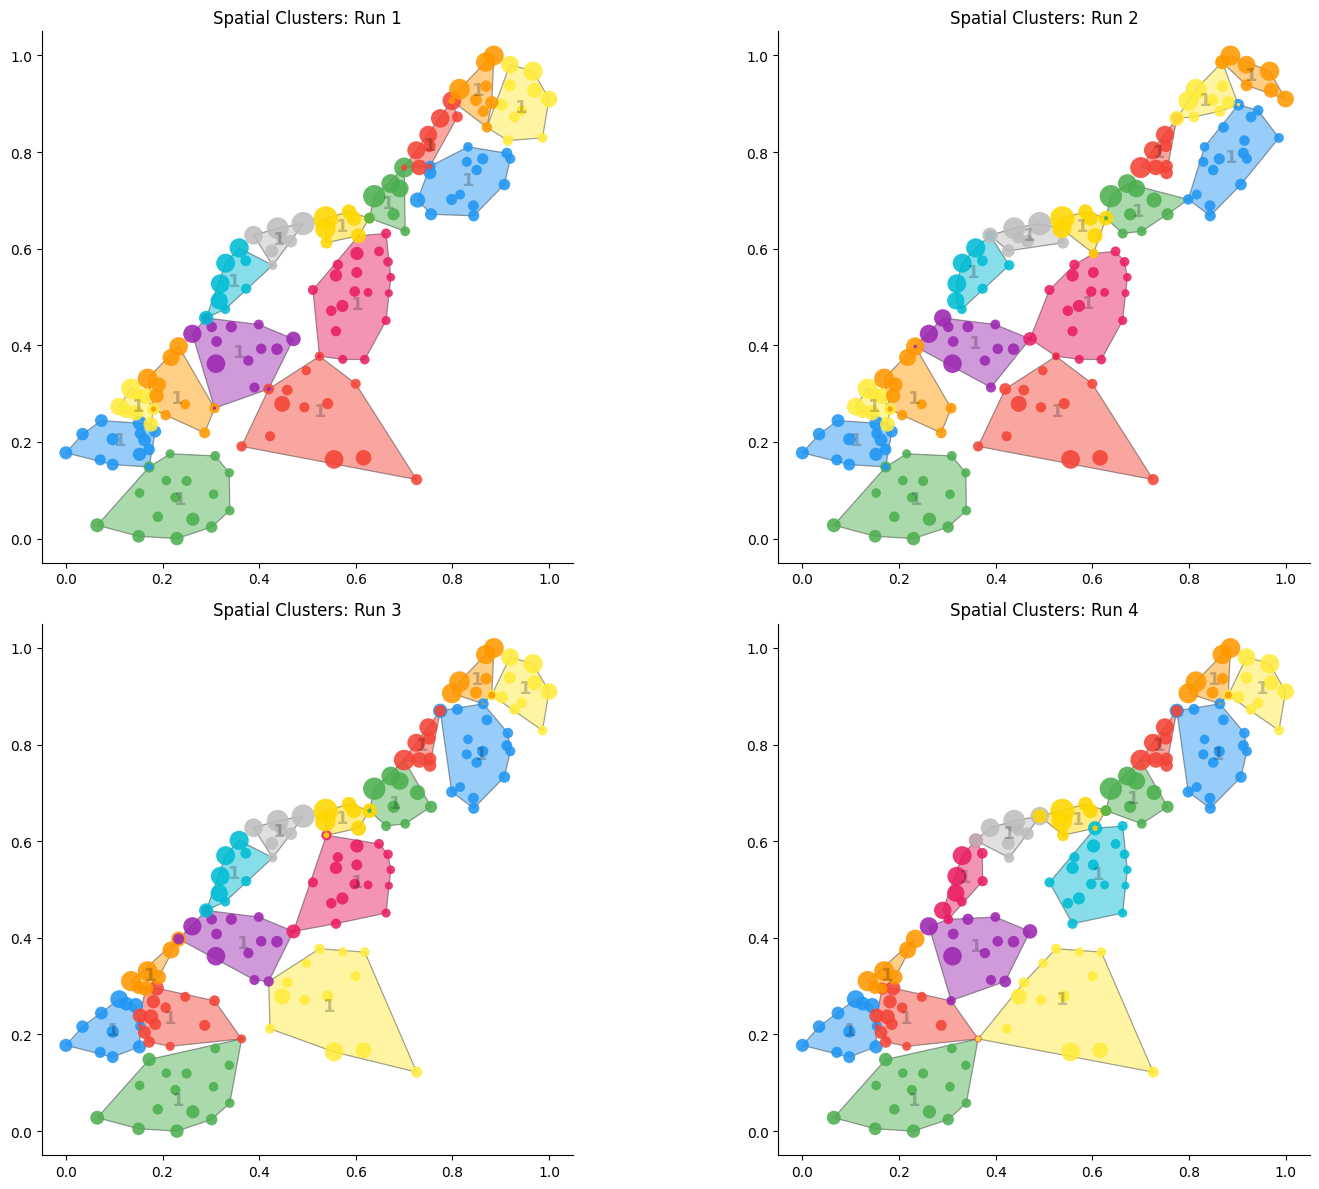

In [61]:
import matplotlib.pyplot as plt

n = len(kss_list)
cols = 2  # or any suitable number for your grid
rows = (n + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(8 * cols, 6 * rows))

axes = axes.flatten()

for i, (kss, ax) in enumerate(zip(kss_list, axes)):
    kss.popu.plot(ax=ax)
    ax.set_title(f"Spatial Clusters: Run {i+1}")

# Hide unused axes if any
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [34]:
summary = df.pivot_table(
    columns=['sort'],
    values=['exp_density', 'exp_moran', 'var_density', 'var_moran'],
    index=['zones'],
    aggfunc='first'
)

summary

KeyError: 'sort'